In [1]:
import pyspark
from pyspark.sql import SparkSession
from graphframes import GraphFrame

import networkx as nx
from matplotlib import pyplot as plt
from igraph import Graph, plot

# Example of PySpark and GraphFrame

## Create graph

In [2]:
spark = SparkSession.builder.appName("build_example_graph").getOrCreate()

In [3]:
vertices = spark.createDataFrame(
    [
        ("1", "Carter", "Derrick", 50),
        ("2", "May", "Derrick", 26),
        ("3", "Mills", "Jeff", 80),
        ("4", "Hood", "Robert", 65),
        ("5", "Banks", "Mike", 93),
        ("98", "Berg", "Tim", 28),
        ("99", "Page", "Allan", 16),
    ],
    ["id", "name", "firstname", "age"],
)
edges = spark.createDataFrame(
    [
        ("1", "2", "friend"),
        ("2", "1", "friend"),
        ("3", "1", "friend"),
        ("1", "3", "friend"),
        ("2", "3", "follows"),
        ("3", "4", "friend"),
        ("4", "3", "friend"),
        ("5", "3", "friend"),
        ("3", "5", "friend"),
        ("4", "5", "follows"),
        ("98", "99", "friend"),
        ("99", "98", "friend"),
    ],
    ["src", "dst", "type"],
)

In [21]:
g = GraphFrame(vertices, edges)

In [22]:
# Take a look at the DataFrames
g.vertices.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+



In [23]:
g.edges.show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+



In [24]:
# Check the number of edges of each vertex
g.degrees.show()

+---+------+
| id|degree|
+---+------+
|  3|     7|
| 98|     2|
| 99|     2|
|  5|     3|
|  1|     4|
|  4|     3|
|  2|     3|
+---+------+



## Visualize graph

In [25]:
# Using networkx
def PlotGraph(edge_list):
    Gplot = nx.Graph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    plt.subplot(121)
    nx.draw(Gplot)

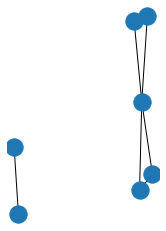

In [26]:
PlotGraph(g.edges)

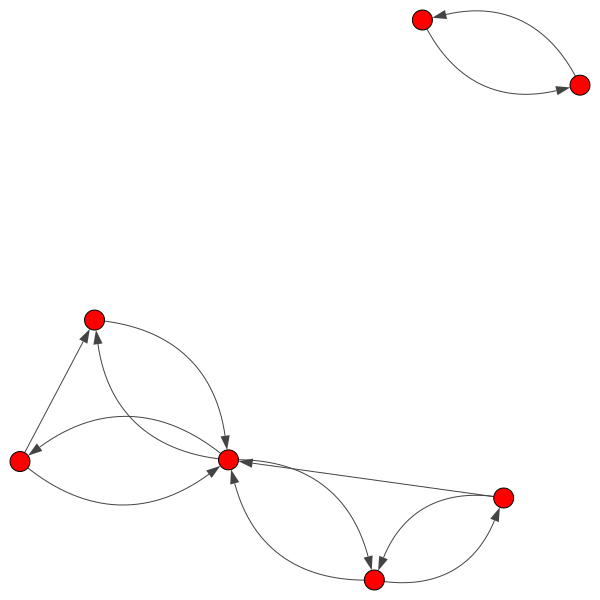

In [31]:
# Using igraph
ig = Graph.TupleList(g.edges.collect(), directed=True)
plot(ig)

## Subgraphs

In [32]:
from graphframes.examples import Graphs

g = Graphs(sqlContext).friends()  # Get example graph

# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")
# In Spark 1.5+, the user may simplify this call:
#  val e2 = paths.select("e.*")

# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)

In [33]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



In [34]:
g2.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



In [35]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



In [36]:
g2.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  e|  f|      follow|
|  c|  b|      follow|
+---+---+------------+

